## Imports

In [1]:
%pip install pinecone-client datasets PyTDC rdkit datamol pandas numpy molfeat mols2grid tensorflow molecule_generation safe-mol


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of pytdc to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12

In [2]:
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tdc.generation import MolGen
from pinecone import Pinecone, ServerlessSpec
import datamol as dm
from datamol.similarity import cdist
import molfeat
from molfeat.calc import FPCalculator, RDKitDescriptors2D
from molfeat.trans import MoleculeTransformer
from molfeat.store.modelstore import ModelStore
from molfeat.trans.pretrained import PretrainedMolTransformer, GraphormerTransformer
import mols2grid
import rdkit
from rdkit import Chem
import tensorflow as tf
import safe as sf

## Load data

In [3]:
from tdc.generation import MolGen
data = MolGen(name = 'ZINC')
split = data.get_split() 

Found local copy...
Loading...
Done!


In [4]:
split

{'train':                                                    smiles
 0                 CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
 1       N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...
 2                 CC[NH+](CC)[C@](C)(CC)[C@H](O)c1cscc1Br
 3                    O=C(Nc1nc[nH]n1)c1cccnc1Nc1cccc(F)c1
 4         Cc1c(/C=N/c2cc(Br)ccn2)c(O)n2c(nc3ccccc32)c1C#N
 ...                                                   ...
 174613      COc1cc(C[NH2+]C[C@@H](C)C[C@@H](C)O)cc(Br)c1O
 174614                       COC(=O)c1cccc2nc(C=O)[nH]c12
 174615   CC1(C)CC[C@H](CNC(=O)Cn2ncc3ccccc3c2=O)c2ccccc21
 174616  Cn1ccnc1C(=O)c1ccc(NC(=O)C2CCN(C(=O)C(C)(C)C)C...
 174617             Cc1ccc(NC(=O)C(=O)N(C)Cc2ccccc2)c(C)c1
 
 [174618 rows x 1 columns],
 'valid':                                                   smiles
 0        C[C@@H](NC(=O)c1ccc(Br)cc1-n1cncn1)[C@@H]1CCOC1
 1          Cc1nc(N[C@@H](C)c2ccccc2-n2cccn2)c2nc(C)oc2n1
 2          CSc1ncc(C(=O)Nc2cccc(C(C)=O)c2)n1-c1ccc(F)cc1
 3         C

In [72]:
valid_df = valid_df.rename(columns = {'SMILES': 'smiles'})

In [73]:
mols = dm.convert.from_df(valid_df)

In [5]:
mols = dm.convert.from_df(split['test'])

In [6]:
## Make synthetic data for the 101st molecule

In [7]:
split['test'].iloc[100]

smiles    O=C(C[C@H]1CC[C@@H](C(=O)[O-])C1)c1ccc(Cl)cc1
Name: 100, dtype: object

In [8]:
query = split['test'].iloc[100].smiles

In [9]:
query

'O=C(C[C@H]1CC[C@@H](C(=O)[O-])C1)c1ccc(Cl)cc1'

## Generate test set
(novel molecules similar to fentanyl)

In [29]:
def compute_tanimoto(mol1, mol2):
    mol1 = Chem.MolFromSmiles(mol1)
    mol2 = Chem.MolFromSmiles(mol2)
    x = 1 - cdist([mol1], [mol2])[0]
    return x[0]

In [16]:
from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

In [20]:
# Function to run unconditional generation from a single SMILES
def gen_mol(smiles, coati_version = 1, num_variations = 100, noise_scale = 0.15):

    # Embed the SMILES
    smiles = Chem.CanonSmiles(smiles)
    if coati_version == 1:
        vector = embed_smiles(smiles, encoder1, tokenizer1)
    elif coati_version == 2:
        vector = embed_smiles(smiles, encoder2, tokenizer2)

    # Noise is added as an isotropic Gaussian with std=noise_scale
    if coati_version == 1:
        nearby_smiles = encoder1.hclip_to_2d_batch(
            h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer1,
            noise_scale=noise_scale,
        )
    elif coati_version == 2:
        nearby_smiles = encoder2.hcoati_to_2d_batch(
            h_coati=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer2,
            noise_scale=noise_scale,
        )

In [25]:
unique_valid_smiles_0p05_1 = gen_mol(smiles_str, coati_version = 1, num_variations = 100, noise_scale = 0.05)


In [33]:
# Model parameters are pulled from the url and stored in a local models/ dir.
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    # device=DEVICE,
    # model parameters to load.
    doc_url="s3://terray-public/models/e3gnn_smiles_clip_e2e_1685977071_1686087379.pkl",
)

Loading model from s3://terray-public/models/e3gnn_smiles_clip_e2e_1685977071_1686087379.pkl
File downloaded successfully to ./models/e3gnn_smiles_clip_e2e_1685977071_1686087379.pkl
Loading tokenizer may from s3://terray-public/models/e3gnn_smiles_clip_e2e_1685977071_1686087379.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
22235904 params frozen!


reference molecule:


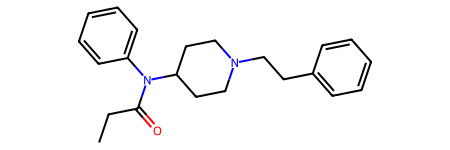

Generated molecules (noise std=0.3):


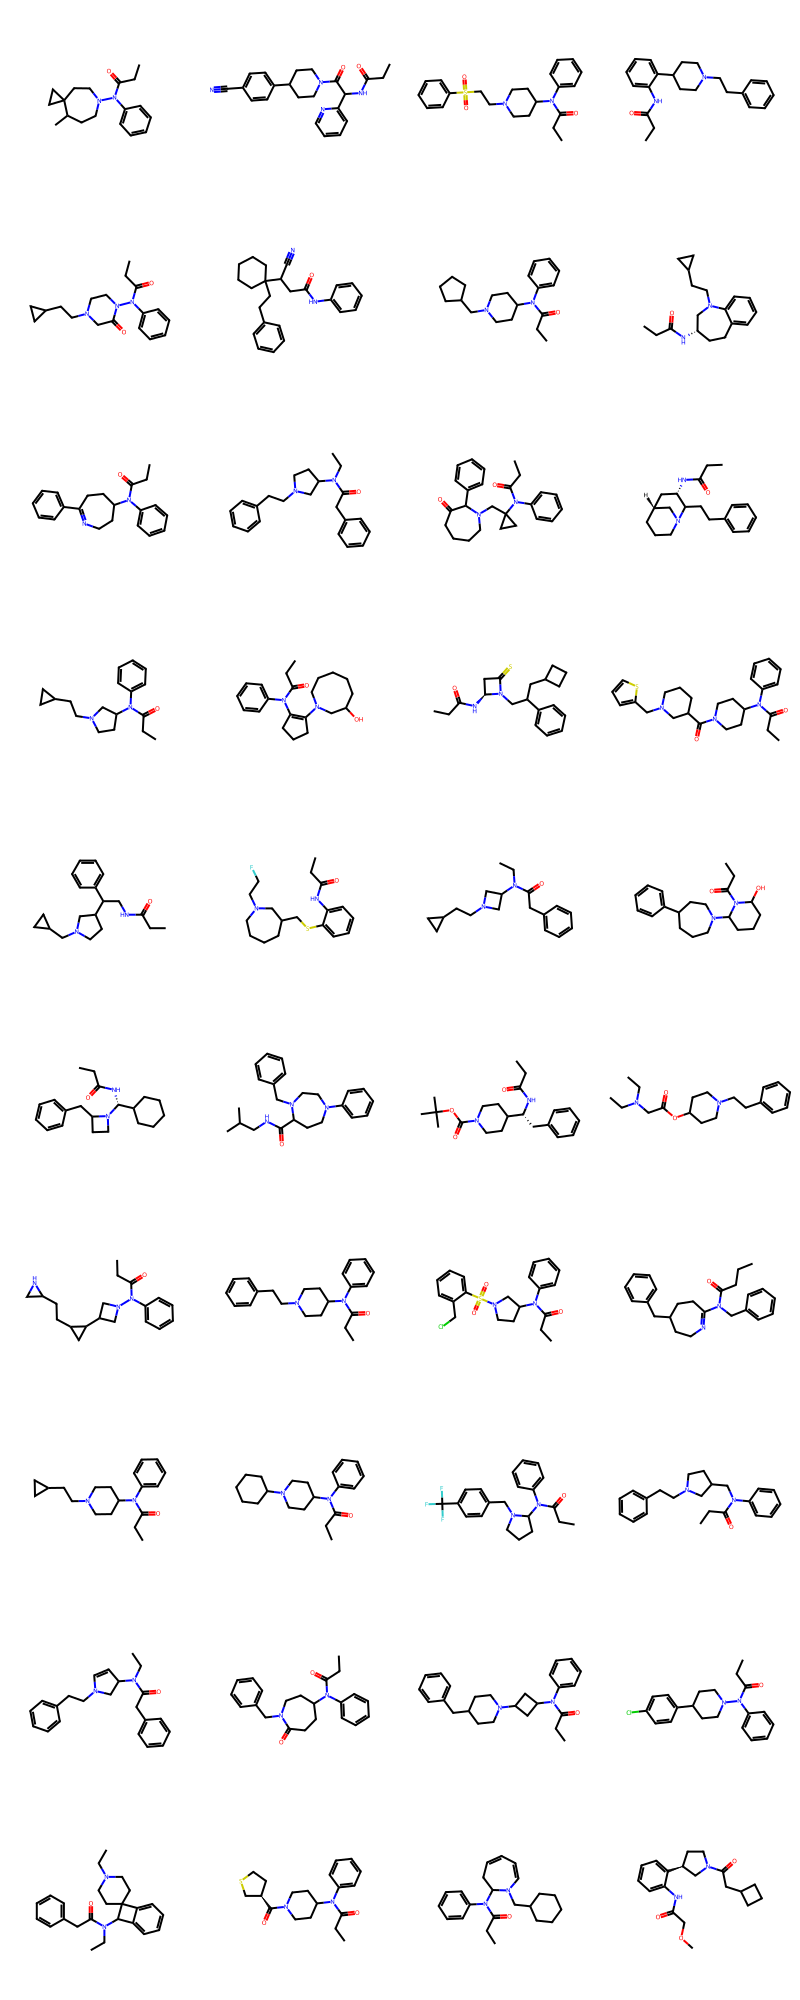

In [59]:
from coati.generative.coati_purifications import embed_smiles

# In this example, we use fentanyl as a reference molecule.
fentanyl_smiles = "CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3"
print("reference molecule:")
display(Chem.MolFromSmiles(fentanyl_smiles))

# We first convert the smiles to canonical smiles which is required by the model.
fentanyl_canonical_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(fentanyl_smiles))
# We then embed the canonical smiles to a 256D vector using the model.
fentanyl_vector = embed_smiles(fentanyl_canonical_smiles, encoder, tokenizer)

# We then generate 30 molecules near fentanyl. We do this by adding noise to the
# embedding vector which is then injected into the embed token in the prefix.
# The generated molecules are decoded back to smiles.
num_variations = 100
# noise is added as an isotropic Gaussian with std=noise_scale.
# noise_scale = 0.3
smiles_near_fentanyl = encoder.hclip_to_2d_batch(
    h_clip=fentanyl_vector.unsqueeze(0).repeat(num_variations, 1),
    tokenizer=tokenizer,
    noise_scale=0.35,
)

# Visualize the generated molecules.
# Note that generated molecules are not guaranteed to be valid.
# Here we also use the set() function to remove duplicates.
print(f"Generated molecules (noise std={noise_scale}):")
display(
    Chem.Draw.MolsToGridImage(
        [
            Chem.MolFromSmiles(s)
            for s in set(smiles_near_fentanyl)
            if not Chem.MolFromSmiles(s) is None
        ],
        molsPerRow=4,
        useSVG=True,
    )
)

In [60]:
len(smiles_near_fentanyl)

100

In [61]:
valid_smiles = [s for s in set(smiles_near_fentanyl) if not Chem.MolFromSmiles(s) is None]

In [62]:
len(valid_smiles)

40

In [63]:
valid_df = pd.DataFrame()

In [64]:
valid_df['SMILES'] = valid_smiles

In [65]:
valid_df

,SMILES
0,CCC(=O)N(c1ccccc1)N1CCC(C)C2(CC2)CC1
1,CCC(=O)NC(c1ccccn1)C(=O)N1CCC(c2ccc(C#N)cc2)CC1
2,CCC(=O)N(c1ccccc1)C1CCN(CCS(=O)(=O)c2ccccc2)CC1
3,CCC(=O)Nc1ccccc1C1CCN(CCc2ccccc2)CC1
4,CCC(=O)N(c1ccccc1)N1CCN(CCC2CC2)CC1=O
5,N#CC(CC(=O)Nc1ccccc1)C1(CCc2ccccc2)CCCCC1
6,CCC(=O)N(c1ccccc1)C1CCN(CC2CCCC2)CC1
7,CCC(=O)N[C@H]1C[C@H]c2ccccc2N(CCC2CC2)C1
8,CCC(=O)N(c1ccccc1)C1CCN=C(-c2ccccc2)CC1
9,CCN(C(=O)Cc1ccccc1)C1CN(CCc2ccccc2)CC1


In [66]:
valid_df['tanimoto'] = valid_df['SMILES'].apply(compute_tanimoto, args = (fentanyl_canonical_smiles,))

In [67]:
valid_df

,SMILES,tanimoto
0,CCC(=O)N(c1ccccc1)N1CCC(C)C2(CC2)CC1,0.297619
1,CCC(=O)NC(c1ccccn1)C(=O)N1CCC(c2ccc(C#N)cc2)CC1,0.169811
2,CCC(=O)N(c1ccccc1)C1CCN(CCS(=O)(=O)c2ccccc2)CC1,0.619718
3,CCC(=O)Nc1ccccc1C1CCN(CCc2ccccc2)CC1,0.437500
4,CCC(=O)N(c1ccccc1)N1CCN(CCC2CC2)CC1=O,0.310345
5,N#CC(CC(=O)Nc1ccccc1)C1(CCc2ccccc2)CCCCC1,0.185567
6,CCC(=O)N(c1ccccc1)C1CCN(CC2CCCC2)CC1,0.588235
7,CCC(=O)N[C@H]1C[C@H]c2ccccc2N(CCC2CC2)C1,0.171717
8,CCC(=O)N(c1ccccc1)C1CCN=C(-c2ccccc2)CC1,0.423077
9,CCN(C(=O)Cc1ccccc1)C1CN(CCc2ccccc2)CC1,0.473684


## Featurize

In [75]:
df = dm.descriptors.batch_compute_many_descriptors(mols, properties_fn=None, add_properties=True, n_jobs=-1, batch_size='auto', progress=False, progress_leave=True)

In [76]:
df['mols'] = mols

In [77]:
df['mol_id'] = [f'Fentanyl_Gen {i}' for i, _ in enumerate(df.mw)]

In [78]:
df

,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,...,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings,mols,mol_id
0,286.204513,0.611111,3,0,3,3,21,3,0,23.55,...,1,2,1,0,1,1,1,2,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0510>,Fentanyl_Gen 0
1,376.189926,0.363636,6,1,3,6,28,5,0,86.09,...,1,1,1,1,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0580>,Fentanyl_Gen 1
2,400.182064,0.409091,5,0,3,6,28,7,0,57.69,...,1,1,2,0,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c04a0>,Fentanyl_Gen 2
3,336.220164,0.409091,3,1,3,3,25,6,0,32.34,...,1,1,2,0,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0660>,Fentanyl_Gen 3
4,315.194677,0.555556,5,0,3,5,23,6,0,43.86,...,1,2,1,0,1,1,1,2,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c06d0>,Fentanyl_Gen 4
5,360.220164,0.416667,3,1,3,3,27,7,0,52.89,...,0,1,2,0,2,1,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c05f0>,Fentanyl_Gen 5
6,314.235814,0.650000,3,0,3,3,23,5,0,23.55,...,1,2,1,0,1,1,1,2,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0740>,Fentanyl_Gen 6
7,285.196688,0.555556,3,1,3,3,21,5,1,32.34,...,1,2,1,0,1,1,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c07b0>,Fentanyl_Gen 7
8,320.188863,0.333333,3,0,3,3,24,4,0,32.67,...,1,1,2,0,2,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0900>,Fentanyl_Gen 8
9,336.220164,0.409091,3,0,3,3,25,7,0,23.55,...,1,1,2,0,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c09e0>,Fentanyl_Gen 9


In [79]:
# # List all available featurizers
store = ModelStore()
store.available_models
model_card = store.search(name='pcqm4mv2_graphormer_base')[0]

In [14]:
store.available_models

[ModelInfo(name='cats2d', inputs='smiles', type='hashed', version=0, group='all', submitter='Datamol', description='2D version of the 6 Potential Pharmacophore Points CATS (Chemically Advanced Template Search) pharmacophore. This version differs from `pharm2D-cats` on the process to make the descriptors fuzzy, which is closer to the original paper implementation. Implementation is based on work by Rajarshi Guha (08/26/07) and Chris Arthur (1/11/2015)', representation='vector', require_3D=False, tags=['CATS', 'hashed', '2D', 'pharmacophore', 'search'], authors=['Michael Reutlinger', 'Christian P Koch', 'Daniel Reker', 'Nickolay Todoroff', 'Petra Schneider', 'Tiago Rodrigues', 'Gisbert Schneider', 'Rajarshi Guha', 'Chris Arthur'], reference='https://doi.org/10.1021/ci050413p', created_at=datetime.datetime(2023, 7, 20, 9, 40, 19, 315784), sha256sum='9c298d589a2158eb513cb52191144518a2acab2cb0c04f1df14fca0f712fa4a1', model_usage=None),
 ModelInfo(name='cats3d', inputs='mol', type='hashed', 

In [80]:
# featurizer = GraphormerTransformer(kind='pcqm4mv2_graphormer_base', dtype=np.float32, pooling='mean', max_length=None, concat_layers=-1, ignore_padding=True, version=None)
featurizer = PretrainedMolTransformer(kind='ChemGPT-1.2B', dtype=np.float32, pooling='mean', max_length=None, concat_layers=-1, ignore_padding=True, version=None)

In [81]:
# calc = FPCalculator("ecfp")
calc = RDKitDescriptors2D(replace_nan=True)

In [82]:
featurizer = MoleculeTransformer(calc, dtype=np.float32)

with dm.without_rdkit_log():
    feats = np.stack(featurizer(mols))

feats.shape

(40, 216)

## Configure Pinecone index

In [83]:
pc = Pinecone(api_key= "c2c9ba1d-9710-472b-a950-a3db5b40a67c")

In [84]:
index = pc.Index('molsearch')

### Upsert vectors

In [85]:
id_list = [f'Fentanyl_Gen {i}' for i, _ in enumerate(feats)]

In [86]:
payload = zip(id_list, feats)

In [90]:
def chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [91]:
for ids_vectors_chunk in chunks(payload, batch_size=10):
    index.upsert(vectors=ids_vectors_chunk) 

## Similarity search

In [ ]:
## Get 101st molecule and search

In [92]:
with dm.without_rdkit_log():
    feats = np.stack(featurizer(Chem.MolFromSmiles(fentanyl_canonical_smiles)))


In [93]:
query_results = index.query(vector = feats.tolist()[0], top_k = 100)

In [94]:
result_id = [query_results['matches'][id_no]['id'] for id_no in range(len(query_results['matches'])) ]

In [95]:
len(result_id)

100

In [10]:
import torch

In [14]:
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e

# set your device
DEVICE = torch.device('cpu')

In [15]:
# Model parameters are pulled from the url and stored in a local models/ dir.
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url="s3://terray-public/models/grande_closed.pkl",
)

Loading model from s3://terray-public/models/grande_closed.pkl


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
import coati
from coati.generative.coati_purifications import embed_smiles

# In this example, we use fentanyl as a reference molecule.
fentanyl_smiles = "CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3"
print("reference molecule:")
display(Chem.MolFromSmiles(fentanyl_smiles))

# We first convert the smiles to canonical smiles which is required by the model.
fentanyl_canonical_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(fentanyl_smiles))
# We then embed the canonical smiles to a 256D vector using the model.
fentanyl_vector = embed_smiles(fentanyl_canonical_smiles, encoder, tokenizer)

# We then generate 30 molecules near fentanyl. We do this by adding noise to the
# embedding vector which is then injected into the embed token in the prefix.
# The generated molecules are decoded back to smiles.
num_variations = 30
# noise is added as an isotropic Gaussian with std=noise_scale.
noise_scale = 0.3
smiles_near_fentanyl = encoder.hclip_to_2d_batch(
    h_clip=fentanyl_vector.unsqueeze(0).repeat(num_variations, 1),
    tokenizer=tokenizer,
    noise_scale=0.25,
)

# Visualize the generated molecules.
# Note that generated molecules are not guaranteed to be valid.
# Here we also use the set() function to remove duplicates.
print(f"Generated molecules (noise std={noise_scale}):")
display(
    Chem.Draw.MolsToGridImage(
        [
            Chem.MolFromSmiles(s)
            for s in set(smiles_near_fentanyl)
            if not Chem.MolFromSmiles(s) is None
        ],
        molsPerRow=4,
        useSVG=True,
    )
)

## Analyze hit similarity

In [ ]:
## Can estimate precision (> Tanimoto threshold in the returned set)
## Recall (Tanimoto for all in the dataset and see if retrieved top 100)
## Tanimoto as ground truth here


In [96]:
def compute_tanimoto(mol1, mol2):
    x = 1 - cdist([mol1], [mol2])[0]
    return x[0]
    

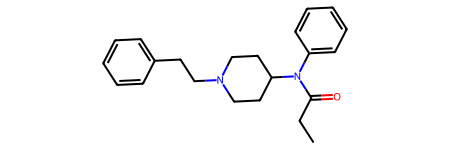

In [98]:
Chem.MolFromSmiles(fentanyl_canonical_smiles)

In [104]:
result_id

['Fentanyl_Gen 25',
 'Fentanyl_Gen 9',
 'Fentanyl_Gen 31',
 'Fentanyl_Gen 3',
 'Fentanyl_Gen 21',
 'Fentanyl_Gen 27',
 'Fentanyl_Gen 32',
 'Fentanyl_Gen 34',
 'Fentanyl_Gen 35',
 'Fentanyl_Gen 15',
 'Fentanyl_Gen 8',
 'Molecule 46',
 'Fentanyl_Gen 38',
 'Fentanyl_Gen 36',
 'Molecule 12',
 'Molecule 50',
 'Fentanyl_Gen 10',
 'Fentanyl_Gen 5',
 'Fentanyl_Gen 30',
 'Molecule 74',
 'Fentanyl_Gen 13',
 'Fentanyl_Gen 7',
 'Fentanyl_Gen 33',
 'Molecule 96',
 'Molecule 91',
 'Molecule 87',
 'Fentanyl_Gen 2',
 'Molecule 95',
 'Fentanyl_Gen 24',
 'Fentanyl_Gen 4',
 'Fentanyl_Gen 0',
 'Fentanyl_Gen 12',
 'Fentanyl_Gen 39',
 'Molecule 41',
 'Fentanyl_Gen 18',
 'Molecule 88',
 'Fentanyl_Gen 14',
 'Molecule 53',
 'Molecule 56',
 'Fentanyl_Gen 28',
 'Molecule 7',
 'Molecule 85',
 'Fentanyl_Gen 11',
 'Molecule 27',
 'Fentanyl_Gen 16',
 'Molecule 59',
 'Fentanyl_Gen 22',
 'Fentanyl_Gen 26',
 'Molecule 21',
 'Fentanyl_Gen 19',
 'Fentanyl_Gen 1',
 'Fentanyl_Gen 37',
 'Molecule 36',
 'Fentanyl_Gen 6',
 'M

In [99]:
df_results = df[df['mol_id'].isin(result_id)]

In [102]:
df_results['tanimoto'] = df_results['mols'].apply(compute_tanimoto, args= (Chem.MolFromSmiles(fentanyl_canonical_smiles), ))

In [103]:
df_results

,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,...,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings,mols,mol_id,tanimoto
0,286.204513,0.611111,3,0,3,3,21,3,0,23.55,...,2,1,0,1,1,1,2,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0510>,Fentanyl_Gen 0,0.297619
1,376.189926,0.363636,6,1,3,6,28,5,0,86.09,...,1,1,1,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0580>,Fentanyl_Gen 1,0.169811
2,400.182064,0.409091,5,0,3,6,28,7,0,57.69,...,1,2,0,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c04a0>,Fentanyl_Gen 2,0.619718
3,336.220164,0.409091,3,1,3,3,25,6,0,32.34,...,1,2,0,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0660>,Fentanyl_Gen 3,0.437500
4,315.194677,0.555556,5,0,3,5,23,6,0,43.86,...,2,1,0,1,1,1,2,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c06d0>,Fentanyl_Gen 4,0.310345
5,360.220164,0.416667,3,1,3,3,27,7,0,52.89,...,1,2,0,2,1,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c05f0>,Fentanyl_Gen 5,0.185567
6,314.235814,0.650000,3,0,3,3,23,5,0,23.55,...,2,1,0,1,1,1,2,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0740>,Fentanyl_Gen 6,0.588235
7,285.196688,0.555556,3,1,3,3,21,5,1,32.34,...,2,1,0,1,1,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c07b0>,Fentanyl_Gen 7,0.171717
8,320.188863,0.333333,3,0,3,3,24,4,0,32.67,...,1,2,0,2,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0900>,Fentanyl_Gen 8,0.423077
9,336.220164,0.409091,3,0,3,3,25,7,0,23.55,...,1,2,0,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c09e0>,Fentanyl_Gen 9,0.473684


In [39]:
mols2grid.display(df_results, mol_col = 'mols', subset = ['mol_id', 'img', 'tanimoto'])

MolGridWidget()

In [107]:
df_results

,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,...,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings,mols,mol_id,tanimoto
0,286.204513,0.611111,3,0,3,3,21,3,0,23.55,...,2,1,0,1,1,1,2,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0510>,Fentanyl_Gen 0,0.297619
1,376.189926,0.363636,6,1,3,6,28,5,0,86.09,...,1,1,1,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0580>,Fentanyl_Gen 1,0.169811
2,400.182064,0.409091,5,0,3,6,28,7,0,57.69,...,1,2,0,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c04a0>,Fentanyl_Gen 2,0.619718
3,336.220164,0.409091,3,1,3,3,25,6,0,32.34,...,1,2,0,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0660>,Fentanyl_Gen 3,0.437500
4,315.194677,0.555556,5,0,3,5,23,6,0,43.86,...,2,1,0,1,1,1,2,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c06d0>,Fentanyl_Gen 4,0.310345
5,360.220164,0.416667,3,1,3,3,27,7,0,52.89,...,1,2,0,2,1,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c05f0>,Fentanyl_Gen 5,0.185567
6,314.235814,0.650000,3,0,3,3,23,5,0,23.55,...,2,1,0,1,1,1,2,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0740>,Fentanyl_Gen 6,0.588235
7,285.196688,0.555556,3,1,3,3,21,5,1,32.34,...,2,1,0,1,1,0,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c07b0>,Fentanyl_Gen 7,0.171717
8,320.188863,0.333333,3,0,3,3,24,4,0,32.67,...,1,2,0,2,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c0900>,Fentanyl_Gen 8,0.423077
9,336.220164,0.409091,3,0,3,3,25,7,0,23.55,...,1,2,0,2,0,1,1,<rdkit.Chem.rdchem.Mol object at 0x7f76ab4c09e0>,Fentanyl_Gen 9,0.473684


Text(0.5, 1.0, 'Tanimoto distribution')

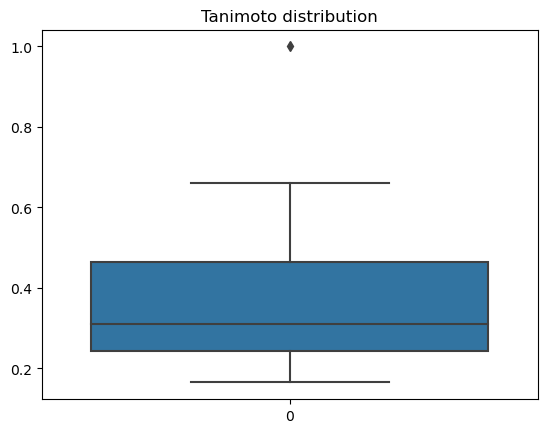

In [106]:
sns.boxplot(df_results['tanimoto'])
plt.title('Tanimoto distribution')